## Imports, function and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
def display_scores(name, gsearch, xtrain, xtest, ytrain, ytest):
    """ the function takes a fitted gridsearchcv as the arguement and
    displays scores
    """
    print('='*30)
    print(f"\033[1m {name} \033[0m".center(38, "="))
    print('='*30)
    print('\nScores:')
    print('-'*30, '\n')
    print('train score:', round(gsearch.score(xtrain, ytrain),2))
    print('test score:', round(gsearch.score(xtest, ytest),2))
    print('cross-validated score:', round(gsearch.best_score_,2))
    print('')
    print(" Best Parameters:")
    print('-'*30, '\n')
    for key, value in gsearch.best_params_.items():
        print(key,':', value)

In [3]:
def plot_cmatrix(ytest, predict):
    """ plot rome/greece confusion matrix and recall/accuracy stats,
    renamed, as there are no real 'positive' or 'negative' outcome
    """
    cm = pd.DataFrame(confusion_matrix(ytest, predict),
                 index=[' Actual Rome', 'Actual Greece'],
                 columns=['Predicted Rome', 'Predicted Greece'])
    tn, fp, fn, tp = confusion_matrix(ytest, predict).ravel()
    
    print('\n\n***Confusion Matrix***\n')
    display(cm)
    print('\nScores:')
    print('-'*30, '\n')
    print('Rome recall:    ', round(tn/(tn+fp),2))
    print('Rome precision:  ', round(tn/(tn+fn),2))
    print('Greece recall:  ', round(tp/(tp+fn),2))
    print('Greece precision:', round(tp/(tp+fp),2))

In [4]:
def topwords_bar(x, y, xlabel, model):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.barplot(x = x, y = y)
    plt.title(f'Top 30 Predictive Words - {model}', fontsize=14, 
             color='Darkorchid')
    plt.xlabel(xlabel, fontsize=12, color='darkgoldenrod')
    plt.ylabel('')
    plt.show()

In [5]:
# pasted over from the previous file
my_stopwords = ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece',
                'greeks', 'amp', 'know', 'like', 'make', 'look', 'just',
                'use', 'really', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻',
                '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹', '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹',
                '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁',
                '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳',
                '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍',
                '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯', '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙',
                '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚',
                '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨',
                '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚',
                '𝙩𝙝𝙚𝙮', '𝙩𝙤', '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']

# my_stopwords2 =  ['ádám', 'ένα', 'αν', 'από', 'αρχαία', 'αἰδοῖον', 'γε', 'για', 'δεν', 'είναι', 'ζωή', 'θα', 'και', 'καὶ',
#                'κύβος', 'λοιμοῦ', 'με', 'μου', 'νέο', 'να', 'νεφέλην', 'οι', 'που', 'σε', 'στο', 'στον', 'τα', 'τη',
#                'την', 'της', 'τι', 'το', 'τον', 'του', 'τους', 'των', 'τῇ', 'τῶν', 'φωτογραφίες', 'χαίρετε', 'χωρίς',
#                'аnd', 'оf', 'раssed', 'עברתי', 'ἀθήναζε', 'ἀνερρίφθω', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹',
#                '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶',
#                '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯',
#                '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧',
#                '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤',
#                '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']

my_stopwords_greek = ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece', 'greeks', 'amp', 'know', 'like', 'make', 
                      'look', 'just', 'use', 'really', 'ádám', 'ένα', 'αν', 'από', 'αρχαία', 'αἰδοῖον', 'γε', 'για',
                      'δεν', 'είναι', 'ζωή', 'θα', 'και', 'καὶ', 'κύβος', 'λοιμοῦ', 'με', 'μου', 'νέο', 'να', 'νεφέλην',
                      'οι', 'που', 'σε', 'στο', 'στον', 'τα', 'τη', 'την', 'της', 'τι', 'το', 'τον', 'του', 'τους', 'των',
                      'τῇ', 'τῶν', 'φωτογραφίες', 'χαίρετε', 'χωρίς', 'аnd', 'оf', 'раssed', 'עברתי', 'ἀθήναζε',
                      'ἀνερρίφθω', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹', '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸',
                      '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥','𝗼𝗳', '𝘁𝗵𝗲',
                      '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯', '𝘽𝙐𝙍𝙉𝙄𝙉𝙂',
                      '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛',
                      '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤',
                      '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']

In [6]:
reddit = pd.read_csv('../datasets/ancients_testing.csv')

In [7]:
reddit.head()

,created_utc,title,selftext,subreddit,posts
0,1641904278,Minoan girl chilling,NaN,1,minoan girl chill
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,1,book reccs for world civ i i m look for a book...
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",1,i start a supplementary twitch stream of assas...
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,NaN,1,dark academia a level ancient athens and spart...
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,1,the ancient greek hero course if you intereste...


## Naive Bayes Models

In [8]:
# split the dataset. this train-test split will be used throughout the notebook
X_train, X_test, y_train, y_test = train_test_split(reddit['posts'],
    reddit['subreddit'], stratify = reddit['subreddit'], random_state=42)

### Baseline Model

In [9]:
display('train', round(y_train.value_counts(normalize=True),3), 'test', round(y_test.value_counts(normalize=True),3))

'train'

0    0.506
1    0.494
Name: subreddit, dtype: float64

'test'

0    0.506
1    0.494
Name: subreddit, dtype: float64

- guessing all 0 (ancientrome) would give us an accuracy score of 0.51 (with a catastrophic recall of 0 for ancientgreece)

In [10]:
# stopwords = text.ENGLISH_STOP_WORDS plus the shorter list of stopwords imported from the previous notebook
stopwords = text.ENGLISH_STOP_WORDS.union(my_stopwords)
len(stopwords)

382

In [11]:
# stopwords_greek = text.ENGLISH_STOP_WORDS.union(my_stopwords2)
# print(len(stopwords_greek))
stopwords2_greek = text.ENGLISH_STOP_WORDS.union(my_stopwords_greek)
print(len(stopwords2_greek))

429


### NB w/cvec

In [12]:
# pipeline with countvectorizer and NB
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords)),
    ('nb', MultinomialNB())
    ])

In [13]:
# parameters for gridsearch
pipe_params = {
    'cvec__max_features': [3000, 4000, 6000,],
    'cvec__min_df':[3, 4],
    'cvec__ngram_range':[(1,2), (1,3)],
    'nb__alpha':[0.1, 0.5, 1, 2]}

In [14]:
gs = GridSearchCV(pipe, pipe_params, cv=6)

In [15]:
gs.fit(X_train, y_train);

In [16]:
print('best params: ', gs.best_params_)
print('train score: ', gs.score(X_train, y_train))
print('test score: ', gs.score(X_test, y_test))
print('crossval score:', gs.best_score_)
pred = gs.predict(X_test)

best params:  {'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.5}
train score:  0.8750601829561868
test score:  0.8101083032490974
crossval score: 0.7922474121896087


**Initial assessment**
- it would initially appear that the scores on test and train data are satisfactory at close to 0.9 and 0.8.
- there is a substantial drop in accuracy between train and test, which needs to be investigated

**Way forward**
- rather than just blindly trying more hyper-parameters and more models, which would actually be quite quick and easy as it would only require slight modification to our pipeline, we think it'd be more prudent to pause and thoroughly investigate the results of the above model. That way we may glean what it is that the model actually does, which words does it use, and how and where does it go wrong. Diving under the hood, we believe, will yield more benefits than just experimenting with random parameters and models

#### Wrong predictions

In [17]:
# get predictions and use our cm plotting function
pred = gs.predict(X_test)
plot_cmatrix(y_test, pred)



***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,561,140
Actual Greece,123,561



Scores:
------------------------------ 

Rome recall:     0.8
Rome precision:   0.82
Greece recall:   0.82
Greece precision: 0.8


In [18]:
# no big insights from the confusion matrix. 
#cut down the X_test dataframe to wrong predictions only next

mydict = {0:'Rome', 1:'Greece'}

# add X_test, pred, and y_test for every wrong prediction to the new 'wrongs' list
wrongs = [list(i) for i in zip(X_test, pred, y_test) if i[1]!=i[2]]

# change 0 and 1 to Rome and Greece for easier reading
for i in wrongs:
    i[1]=mydict[i[1]]
    i[2]=mydict[i[2]]

pd.set_option("max_colwidth", 200) # expend columns to be able to see more text
wrong_df = pd.DataFrame(wrongs, columns = ['text', 'predicted',
                                                'actual'])

wrong_df.head(25) # print 25 wrong predictions to study

,text,predicted,actual
0,byzantines greeks romans or greeks cosplaying a romans so this be a controversial topic especially among roman history enthusiast less among roman history scholar but i want the opinion of some of...,Rome,Greece
1,bettany hughes documentary about the roman god bacchus,Greece,Rome
2,worst omens in ancient history,Rome,Greece
3,saw this today on too good not to post,Greece,Rome
4,hope you recognise a couple of these mince pie design,Rome,Greece
5,saw the kylix of theseus at the british museum a couple day ago,Rome,Greece
6,question about a suppose quote by velleius paterculus hi fellow fan of the ancient times i get a question for the expert in truth about velleius paterculus prologomena write by summer on page he s...,Greece,Rome
7,any map of greece drawn durring the time of the ancient greeks i look for a map of greece date anywhere from ce to ce,Rome,Greece
8,oops,Rome,Greece
9,the great allegory of the west jacob berman history valley the meaning of revelation amp mysteries,Greece,Rome


In [19]:
# after a cursory glance at 25 posts that lead to wrong predictions,
# there seems to be many short posts there

#investigate. create a wordcount column in both wrong_df and reddit df
wrong_df['wordcount'] = wrong_df['text'].str.split().str.len()
reddit['wordcount'] = reddit['posts'].str.split().str.len()
wrong_df.head()

,text,predicted,actual,wordcount
0,byzantines greeks romans or greeks cosplaying a romans so this be a controversial topic especially among roman history enthusiast less among roman history scholar but i want the opinion of some of...,Rome,Greece,374
1,bettany hughes documentary about the roman god bacchus,Greece,Rome,8
2,worst omens in ancient history,Rome,Greece,5
3,saw this today on too good not to post,Greece,Rome,9
4,hope you recognise a couple of these mince pie design,Rome,Greece,10


In [20]:
# check the medians
print('wrong prediction - median words/post: ', wrong_df[
    'wordcount'].median())
print('all predictions - median words/post: ', reddit[
    'wordcount'].median())

wrong prediction - median words/post:  12.0
all predictions - median words/post:  14.0


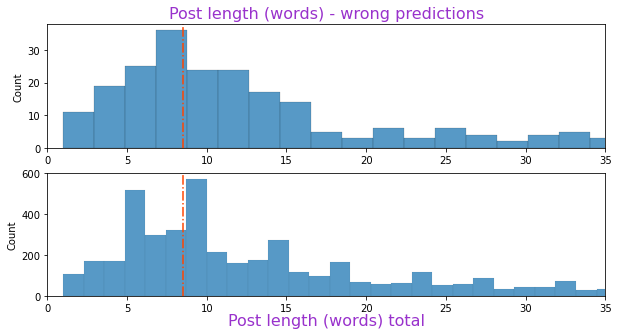

In [87]:
# the medians confirm our suspicions. we should drop shorter posts, but
# where to draw the line?
# let's check the histograms
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax=ax.ravel()
sns.histplot(wrong_df['wordcount'], bins=400, ax=ax[0])
ax[0].set_xlim(0,35)
ax[0].set_xlabel('')
ax[0].set_title('Post length (words) - wrong predictions', fontsize=16, 
               color='darkorchid')
ax[0].axvline(x=8.5, color = 'orangered', linestyle='-.')

sns.histplot(reddit['wordcount'], bins=1400, ax=ax[1])
ax[1].set_title('Post length (words) total', fontsize=16, 
               color='darkorchid', x=0.5, y=-0.28)
ax[1].set_xlim(0,35)
ax[1].set_xlabel('')
ax[1].axvline(x=8.5, color = 'orangered', linestyle='-.')
plt.show()

- it appears that cutting the word length to around 8 could improve results
- this is not just an arbitrary cut undertaken to improve our scores - shorter posts are often spam-y, off-topic, or are just a brief answer to another post, and as such, seldom add value when it comes to the task of training the machine to learn to recognize language used in different ancient history forums

In [22]:
# create a new dataframe with post wordlenght of less than 9.
reddit2 = reddit.drop(reddit.loc[reddit['wordcount']<9].index)

### NB w/cvec & 8+ words

In [23]:
# parameters for gridsearch
pipe_params1 = {
    'cvec__max_features': [2500, 4000, 6000],
    'cvec__min_df':[3, 4],
    'cvec__ngram_range':[(1,2), (1,3)],
    'nb__alpha':[0.1, 0.5, 1, 2]}

In [24]:
# create a new train and test sets from reddit2 data with longer posts. 
# this one will also be used through the remainder of the notebook
X_train1, X_test1, y_train1, y_test1 = train_test_split(reddit2['posts'],
    reddit2['subreddit'], stratify = reddit2['subreddit'], random_state=42)

In [25]:
# pipeline and gridsearch will be the same, the difference will be the training on X_train1, y_train1    
pipe1 = Pipeline([
        ('cvec', CountVectorizer(stop_words=stopwords)),
        ('nb', MultinomialNB())
        ])
 
# same gridsearch, same pipe_params but trained on the new train set  
gs1 = GridSearchCV(pipe1, pipe_params1, cv=6)
gs1.fit(X_train1, y_train1);


print('best params: ', gs1.best_params_)
print('train score: ', gs1.score(X_train1, y_train1))
print('test score: ', gs1.score(X_test1, y_test1))
print('crossval score:', gs1.best_score_)

pred1 = gs1.predict(X_test1)

best params:  {'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3), 'nb__alpha': 2}
train score:  0.8993923024983119
test score:  0.8370445344129555
crossval score: 0.8106035098668812


In [26]:
# the model based on posts longer than 9 words performs better
# we will keep calling the function display_scores after every two models, to take a look at how 
# scores are developing
display_scores('NaiveBayes/cvec',
               gs, X_train, X_test, y_train, y_test)
plot_cmatrix(y_test, pred)
print('\n\n\n')
display_scores('NaiveBayes/cvec&8+words',
               gs1, X_train1, X_test1, y_train1, y_test1)
plot_cmatrix(y_test1, pred1)

====== NaiveBayes/cvec =======

Scores:
------------------------------ 

train score: 0.88
test score: 0.81
cross-validated score: 0.79

 Best Parameters:
------------------------------ 

cvec__max_features : 4000
cvec__min_df : 3
cvec__ngram_range : (1, 2)
nb__alpha : 0.5


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,561,140
Actual Greece,123,561



Scores:
------------------------------ 

Rome recall:     0.8
Rome precision:   0.82
Greece recall:   0.82
Greece precision: 0.8




== NaiveBayes/cvec&8+words ===

Scores:
------------------------------ 

train score: 0.9
test score: 0.84
cross-validated score: 0.81

 Best Parameters:
------------------------------ 

cvec__max_features : 4000
cvec__min_df : 3
cvec__ngram_range : (1, 3)
nb__alpha : 2


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,419,98
Actual Greece,63,408



Scores:
------------------------------ 

Rome recall:     0.81
Rome precision:   0.87
Greece recall:   0.87
Greece precision: 0.81


- as we expected and hoped, there is an improvement in accuracy (0.81 to 0.83 for the test set) after dropping the posts with fewer than 9 words

### NB w/tfidf

In [27]:
pipe_params2 = {
    'tfvec__max_features': [2000, 4000, 6000],
    'tfvec__min_df':[3,4],
    'tfvec__ngram_range':[(1,1), (1,3)],
#     'tfvec__norm':['l2', 'l1'], # it always ends up being l2, so we took this out
    'nb__alpha':[0.1, 0.5, 1, 10]
    }

In [28]:
# TfidfVectorizer()
pipe2 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=stopwords)),
        ('nb', MultinomialNB())
        ])

# new gridsearch with the new pipe and parameters 
# use X_train as that one does not have word limit
gs2 = GridSearchCV(pipe2, pipe_params2, cv=6)
gs2.fit(X_train, y_train);
print('best params: ', gs2.best_params_)
print('train score: ', gs2.score(X_train, y_train))
print('test score: ', gs2.score(X_test, y_test))
print('cross-val score: ', gs2.best_score_)

pred2 = gs2.predict(X_test)

best params:  {'nb__alpha': 0.5, 'tfvec__max_features': 4000, 'tfvec__min_df': 3, 'tfvec__ngram_range': (1, 3)}
train score:  0.9058738565238325
test score:  0.8137184115523466
cross-val score:  0.79321010823901


### NB w/tfidf & 8+ words

In [29]:
pipe_params3 = {
    'tfvec__max_features': [3000, 4000, 5500],
    'tfvec__min_df':[3,4],
    'tfvec__ngram_range':[(1,1), (1,3)],
#     'tfvec__norm':['l2', 'l1'], # it always ends up being l2, so we took this out
    'nb__alpha':[0.1, 0.5, 1, 2]  
    }

In [30]:
pipe3 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=stopwords)),
        ('nb', MultinomialNB())
        ])

# new gridsearch with the new pipe and parameters 
gs3 = GridSearchCV(pipe3, pipe_params3, cv=6)
gs3.fit(X_train1, y_train1);
print('best params: ', gs3.best_params_)
print('train score: ', gs3.score(X_train1, y_train1))
print('test score: ', gs3.score(X_test1, y_test1))
print('cross-val score: ', gs3.best_score_)

pred3 = gs3.predict(X_test1)

best params:  {'nb__alpha': 0.5, 'tfvec__max_features': 4000, 'tfvec__min_df': 3, 'tfvec__ngram_range': (1, 3)}
train score:  0.9341661039837947
test score:  0.847165991902834
cross-val score:  0.8126291700541727


In [31]:
display_scores('NaiveBayes/tfdif',
               gs2, X_train, X_test, y_train, y_test)
plot_cmatrix(y_test, pred2)
print('\n\n\n')
display_scores('NaiveBayes/tfidf&8+words',
               gs3, X_train1, X_test1, y_train1, y_test1)
plot_cmatrix(y_test1, pred3)

====== NaiveBayes/tfdif ======

Scores:
------------------------------ 

train score: 0.91
test score: 0.81
cross-validated score: 0.79

 Best Parameters:
------------------------------ 

nb__alpha : 0.5
tfvec__max_features : 4000
tfvec__min_df : 3
tfvec__ngram_range : (1, 3)


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,570,131
Actual Greece,127,557



Scores:
------------------------------ 

Rome recall:     0.81
Rome precision:   0.82
Greece recall:   0.81
Greece precision: 0.81




== NaiveBayes/tfidf&8+words ==

Scores:
------------------------------ 

train score: 0.93
test score: 0.85
cross-validated score: 0.81

 Best Parameters:
------------------------------ 

nb__alpha : 0.5
tfvec__max_features : 4000
tfvec__min_df : 3
tfvec__ngram_range : (1, 3)


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,434,83
Actual Greece,68,403



Scores:
------------------------------ 

Rome recall:     0.84
Rome precision:   0.86
Greece recall:   0.86
Greece precision: 0.83


 - brief conclusion: tfidf vecorization had a very limited positive effect on the scores (increase in test accuracy of 0.01-0.02. 
 - a more meaningful improvement, in addition to a thorough parameter tuning, is limiting the post size to 8 words or more, as that increses accuracy by 0.03-0.04.
 - next we will try to change the stopwords. we imported two sets of stopwords from our EDA file - so far we've worked with the set that doesn't include ancient greek words. Now we will test models with stopwords that include those words
 - to save time we will not run all 4 models (with and without 8 word limit, and with cvec/tfidf vectorizer. Instead we will run 2 but we'll try to cover all bases by trying CVEC with 8+ words, and TFIDF with all words
 - confusion matrices are still not very interesting - the prediction and mistakes are evenly split among greece and rome

### NB w/cvec, extra stopwords

In [32]:
# parameters for gridsearch, initially copied over from the most similar model, NB cvec 8+ words. finetune it later
pipe_params4 = {
    'cvec__max_features': [2500, 4000, 6000],
    'cvec__min_df':[3, 4],
    'cvec__ngram_range':[(1,2), (1,3)],
    'nb__alpha':[0.1, 0.5, 1, 2]}

In [34]:
# run the new pipeline and gridsearch
pipe4 = Pipeline([
        ('cvec', CountVectorizer(stop_words=stopwords2_greek)), # this is the changed bit, stopwords2_greek
        ('nb', MultinomialNB())
        ])


 
# new gridsearch with the new pipe
gs4 = GridSearchCV(pipe4, pipe_params4, cv=6)
gs4.fit(X_train, y_train)
print('best params: ', gs4.best_params_)
print('train score: ', gs4.score(X_train, y_train))
print('test score: ', gs4.score(X_test, y_test))
print('cross-val score: ', gs4.best_score_)

pred4 = gs4.predict(X_test)

best params:  {'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.5}
train score:  0.8736157920077035
test score:  0.8072202166064982
cross-val score:  0.7903223676345063


### NB w/tfidf, 8+ words, extra stopwords

In [35]:
#start with same parameters as our previous model NB tfidf 

pipe_params5 = {
    'tfvec__max_features': [2000, 4000, 6000],
    'tfvec__min_df':[3,4],
    'tfvec__ngram_range':[(1,1), (1,3)],
#     'tfvec__norm':['l2', 'l1'], # it always ends up being l2, so we took this out
    'nb__alpha':[0.1, 0.5, 1, 10]
    }

In [36]:
# TfidfVectorizer pipeline and gridsearch
pipe5 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=stopwords2_greek)), # change stopwords to the greek ones
        ('nb', MultinomialNB())
        ])


 
# new gridsearch with the new pipe and parameters 
# use X_train1 as that one has word limit
gs5 = GridSearchCV(pipe5, pipe_params5, cv=6)
gs5.fit(X_train1, y_train1);
print('best params: ', gs5.best_params_)
print('train score: ', gs5.score(X_train1, y_train1))
print('test score: ', gs5.score(X_test1, y_test1))
print('cross-val score: ', gs5.best_score_)

pred5 = gs5.predict(X_test1)

best params:  {'nb__alpha': 0.5, 'tfvec__max_features': 4000, 'tfvec__min_df': 3, 'tfvec__ngram_range': (1, 3)}
train score:  0.9318028359216746
test score:  0.8421052631578947
cross-val score:  0.81127827369954


In [37]:
display_scores('NaiveBayes/tfdif',
               gs4, X_train, X_test, y_train, y_test)
plot_cmatrix(y_test, pred4)
print('\n\n\n')
display_scores('NaiveBayes/tfidf&8+words',
               gs5, X_train1, X_test1, y_train1, y_test1)
plot_cmatrix(y_test1, pred5)

====== NaiveBayes/tfdif ======

Scores:
------------------------------ 

train score: 0.87
test score: 0.81
cross-validated score: 0.79

 Best Parameters:
------------------------------ 

cvec__max_features : 4000
cvec__min_df : 3
cvec__ngram_range : (1, 2)
nb__alpha : 0.5


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,560,141
Actual Greece,126,558



Scores:
------------------------------ 

Rome recall:     0.8
Rome precision:   0.82
Greece recall:   0.82
Greece precision: 0.8




== NaiveBayes/tfidf&8+words ==

Scores:
------------------------------ 

train score: 0.93
test score: 0.84
cross-validated score: 0.81

 Best Parameters:
------------------------------ 

nb__alpha : 0.5
tfvec__max_features : 4000
tfvec__min_df : 3
tfvec__ngram_range : (1, 3)


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,431,86
Actual Greece,70,401



Scores:
------------------------------ 

Rome recall:     0.83
Rome precision:   0.86
Greece recall:   0.85
Greece precision: 0.82


### NB models summary
- in general, we are pretty happy with all the models. Train accuracy ranged from 0.87 to 0.94 while the test one was in the 0.80 to 0.85 range
- since many models have similar scores, we will chose our top model based on other factors, such as simplicity and intuitiveness.
- model 2.6, NB w/tfidf, 8+ words and extra stopwords is that model
- it has one of the highest scores 0.93/0.84, uses only longer posts with 8 or more words (which are more like real documents rather than short meme), and it does its learning on smallest set of words as it has the largest list of stop words in its vectorizer, making it very far removed from a 'search machine' which just looks for keywords
- it not as sensitive to tuning, so there's less chance of "hyper-parameter overfitting"
- next we will look at which words this model used to come with its predictions

### NB word importance

In [38]:
# Naive Bayes, in addition to getting good scores, is a great model as it can give us top predictive
# words for both subgroups

# use gs5 (the model from section 2.7) as the model in section 2.9

#subtract log probability of words given class 1 minus class 0
feat_imp = gs5.best_estimator_['nb'].feature_log_prob_[1] - gs5.best_estimator_['nb'].feature_log_prob_[0]

#get word list
feat_names = np.array(gs5.best_estimator_['tfvec'].get_feature_names())

#put the probabilites and words in a dataframe
top_words = pd.DataFrame({'feat_names': feat_names, 'coef': feat_imp})

In [39]:
#print top 30 words for rome
temp_dfr = top_words.sort_values('coef').head(30).rename(
    {'feat_names':'topwords_rome'}, axis=1)
temp_dfr

,topwords_rome,coef
1166,emperor,-3.851595
2429,nero,-2.972516
1798,imperial,-2.852546
2743,pompeii,-2.761415
558,caesar,-2.679190
1606,hadrian,-2.635532
3633,trajan,-2.577665
789,constantine,-2.565150
946,denarius,-2.527914
2188,marcus,-2.474117


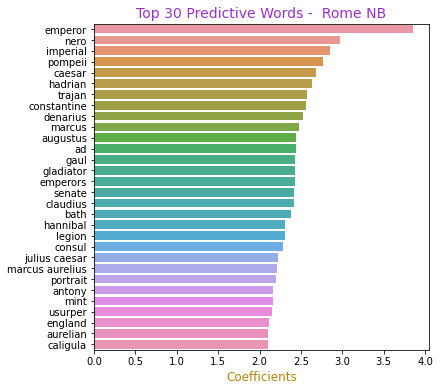

In [40]:
# in the chart form
topwords_bar(np.abs(temp_dfr['coef']), temp_dfr['topwords_rome'],
            'Coefficients', ' Rome NB')

In [41]:
# print top 30 words for greece
top_words.sort_values('coef')[-1:-30:-1].rename({'feat_names':'topwords_greece'}, axis=1)

,topwords_greece,coef
2600,pdf,3.326145
3271,socrates,3.031362
3666,trojan,3.000851
3302,sparta,2.891653
2372,mycenaean,2.834476
2498,odyssey,2.828539
3304,spartan,2.755675
3667,trojan war,2.747196
1449,free pdf,2.654005
2578,parthenon,2.633468


- overall good results, except for the fact that a spam in the form of 'download free pdf books and ebooks' snuck its way into our greek posts. 
- we'll add those to stopwords, and re-run the model a few times until it's clean of spam. hopefully the score doesn't suffer too much
 - but first, we have to check how did all these "download free books" make past our duplicate drops and other cleaning functions

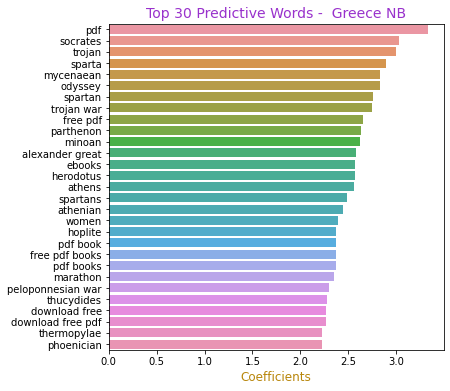

In [42]:
# same table, but in the chart form
topwords_bar(top_words.sort_values('coef')[-1:-30:-1].rename(
    {'feat_names':'topwords_greece'}, axis=1)['coef'], top_words.sort_values(
    'coef')[-1:-30:-1].rename({'feat_names':'topwords_greece'}, axis=1)['topwords_greece'],
            'Coefficients', ' Greece NB')

In [43]:
# what happened? how did 'download free books now' make it past our duplicate drops?
for row in reddit['posts']: # check each for the spam word 'downlaod'
    if 'download' in row:
        print(row)

bettilt download app para android apk amp ios
a student history of greece free pdf by j b bury study ebooks download free pdf ebooks
free giveaway myths and legends of ancient greece book be free for download in the next day and it be a comprehensive introduction into the world of greek myth include detailed retell of the iliad and the odyssey please help yourselves
stoic and epicurean by robert drew hicks free pdf book study ebooks download free pdf ebooks
greek modern with phonetic pronunciation thimm system by nicolaos anastassiou study ebooks download free pdf ebooks
the development of greek philosophy pdf book by robert adamson study ebooks download free pdf ebooks
sculpture egyptian assyrian greek roman with numerous illustration by george redford sharing ebook download free pdf books legally
free giveaway myths and legends of ancient greece book be free for download in the next day it be a comprehensive introduction into the world of greek mythology include detailed retellings o

 - words 'sharingebook download free pdf books legally' had been added to different posts, so it made it past our drop duplicate function
 - remove it

In [81]:
#extend the stopword list
my_stopwords_greek.extend(['pdf', 'ebooks', 'ebook', 'book', 'books', 'download', 'legally', 'free', 'sharingebook'])
stopwords3_greek = text.ENGLISH_STOP_WORDS.union(my_stopwords_greek) 
len(stopwords3_greek)

438

In [82]:
#rerun the model 2.7 with the new list of stopwords
#everthing is exactly the same except for one line (line 4)
pipe6 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=stopwords3_greek)), # change stopwords2 to stopwords3 
        ('nb', MultinomialNB())
        ])


gs6 = GridSearchCV(pipe6, pipe_params5, cv=6)
gs6.fit(X_train1, y_train1);
print('best params: ', gs6.best_params_)
print('train score: ', gs6.score(X_train1, y_train1))
print('test score: ', gs6.score(X_test1, y_test1))
print('cross-val score: ', gs6.best_score_)

pred6 = gs6.predict(X_test1)

best params:  {'nb__alpha': 0.5, 'tfvec__max_features': 4000, 'tfvec__min_df': 3, 'tfvec__ngram_range': (1, 3)}
train score:  0.9338284942606347
test score:  0.840080971659919
cross-val score:  0.8082411521079185


In [83]:
# train and test score is virtually identical to the previous version without the spam words.
# let's see top words again, with the spam removed

feat_imp = gs6.best_estimator_['nb'].feature_log_prob_[1] - gs6.best_estimator_['nb'].feature_log_prob_[0]
feat_names = np.array(gs6.best_estimator_['tfvec'].get_feature_names())
top_words = pd.DataFrame({'feat_names': feat_names, 'coef': feat_imp})

In [84]:
temp_dfg = top_words.sort_values('coef')[-1:-30:-1].rename(
    {'feat_names':'topwords_greece'}, axis=1)
temp_dfg

,topwords_greece,coef
3272,socrates,3.056291
3667,trojan,3.011335
3303,sparta,2.899177
2331,mycenaean,2.844530
2446,odyssey,2.822706
3668,trojan war,2.765404
3305,spartan,2.761344
2256,minoan,2.659583
2552,parthenon,2.659107
107,alexander great,2.601184


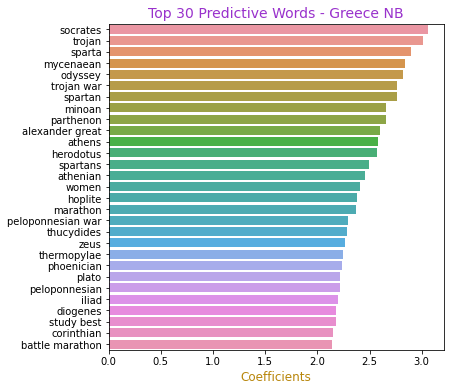

In [85]:
topwords_bar(np.abs(temp_dfg['coef']), temp_dfg['topwords_greece'],
            'Coefficients', 'Greece NB')

 - the new top list now looks relevant to both ancient rome and greece
 - not only did we optimize our NB model, but now we also have more in-depth understanding to bring to bear as we run a Random Forest model next

## Random Forest

 A few thing we will bring over from our NB models are: 
   - X_train, y_train (split with all posts), and X_train1 and y_train1 (with posts with 8 or more words)
   - the most exhaustive stopword list (stopwords3_greek)  
   - as Naive Bayes was the first model we ran in this project, we spent a lot of time optimizing it. Due to that, we are starting the new model with cleaned-up data and stopwords, which should make running the forthcoming models more faster.

### RF w/cvec

In [49]:
pipe_paramsrf1 = {
    'cvec__max_features': [3000, 4000, 5000],
    'rf__n_estimators':[300, 400, 500],
    'rf__max_depth':[4,5],
    'rf__min_samples_leaf': [1,2,3],
    #'rf__ccp_alpha':[0, 0.01], always stays at zero
    'rf__criterion': ['gini', 'entropy']
}

In [50]:
# CountVectorizer pipeline and gridsearch
pipe_rf1 = Pipeline([('cvec', CountVectorizer(ngram_range=(1,3),
        min_df=2, stop_words=stopwords3_greek)), 
        ('rf', RandomForestClassifier(random_state=42))
        ])


 
# new gridsearch with the new pipe and parameters 
# use X_train as that one does not have word limit per post
gs_rf1 = GridSearchCV(pipe_rf1, pipe_paramsrf1, cv=4, n_jobs=4)
gs_rf1.fit(X_train, y_train);


In [51]:
print('best params: ', gs_rf1.best_params_)
print('train score: ', gs_rf1.score(X_train, y_train))
print('test score: ', gs_rf1.score(X_test, y_test))
print('cross-val score: ', gs_rf1.best_score_)

pred_rf1 = gs_rf1.predict(X_test)

best params:  {'cvec__max_features': 4000, 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 300}
train score:  0.807655272026962
test score:  0.7805054151624549
cross-val score:  0.7717884953110019


- after many tries with various hyper-parameter combinations, the above cells produces the best results as far Random Forest is concerned
- results are both good and bad - while the overall scores are lower, there is less overfitting as evidenced by the small dropoff in accuracy from train to test data, from 0.80 to 0.78.
- next try with posts longer than 8 words

### RF w/tfidf & 8+words

In [52]:
pipe_paramsrf2 = {
    'tfidf__max_features': [4000, 6000],
    'rf__n_estimators':[300, 400],
    'rf__max_depth':[6, 12],
    'rf__min_samples_leaf': [1,2,3],
#     'rf__ccp_alpha':[0, 0.01], always stays at zero
    'rf__criterion': ['gini', 'entropy']
}

In [53]:
# CountVectorizer pipeline and gridsearch
pipe_rf2 = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df =2, stop_words=stopwords3_greek)), 
        ('rf', RandomForestClassifier(random_state=42))
        ])

# new gridsearch with the new pipe and parameters 
# use X_train1 as that one does not have word limit per post
gs_rf2 = GridSearchCV(pipe_rf2, pipe_paramsrf2, cv=4, n_jobs=4)
gs_rf2.fit(X_train1, y_train1);

In [54]:
print('best params: ', gs_rf2.best_params_)
print('train score: ', gs_rf2.score(X_train1, y_train1))
print('test score: ', gs_rf2.score(X_test1, y_test1))
print('cross-val score: ', gs_rf2.best_score_)

pred_rf2 = gs_rf2.predict(X_test1)

best params:  {'rf__criterion': 'entropy', 'rf__max_depth': 12, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 300, 'tfidf__max_features': 4000}
train score:  0.8139770425388251
test score:  0.7611336032388664
cross-val score:  0.7586082540029908


In [55]:
display_scores('RForest/cvec',
               gs_rf1, X_train, X_test, y_train, y_test)
plot_cmatrix(y_test, pred_rf1)
print('\n\n\n')
display_scores('RForest/tfidf&8+words',
               gs_rf2, X_train1, X_test1, y_train1, y_test1)
plot_cmatrix(y_test1, pred_rf2)

======== RForest/cvec ========

Scores:
------------------------------ 

train score: 0.81
test score: 0.78
cross-validated score: 0.77

 Best Parameters:
------------------------------ 

cvec__max_features : 4000
rf__criterion : entropy
rf__max_depth : 5
rf__min_samples_leaf : 2
rf__n_estimators : 300


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,476,225
Actual Greece,79,605



Scores:
------------------------------ 

Rome recall:     0.68
Rome precision:   0.86
Greece recall:   0.88
Greece precision: 0.73




=== RForest/tfidf&8+words ====

Scores:
------------------------------ 

train score: 0.81
test score: 0.76
cross-validated score: 0.76

 Best Parameters:
------------------------------ 

rf__criterion : entropy
rf__max_depth : 12
rf__min_samples_leaf : 1
rf__n_estimators : 300
tfidf__max_features : 4000


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,476,41
Actual Greece,195,276



Scores:
------------------------------ 

Rome recall:     0.92
Rome precision:   0.71
Greece recall:   0.59
Greece precision: 0.87


- very interesting results. while NB results did't have much variety in terms of confusion matrix and recall, Random Forest is all over the place.
- with greek-alphabet words kept amongst the features, the first RF model, (3.1) made a bulk of its predictions Greece. Consequently its Greece recall was 20 points higher at 0.88 vs 0.68 for the Rome one. That model also didn't require big depth of tree, which was topping out around 4 to 5.
- once the greek words were removed, the second RF model 3.2 (with tfidf) initially showed much worse results than the first one, but after increasing its depth of trees to 12(!) we managed to get its accuracy up to par with the first one. With higer max_depth there would normally be more overfitting, but that was tolerable at only 0.02 bigger difference between train and test than the first RF model
- also, once the second model (with greek words still removed) started to guess Rome majority of the time. It went from predicted Rome 40% of the time to predicted Rome a whopping 67% of the time.
- we would love to dwell longer on this aspect of the model and why it behaved this way, but we will leave that for later and move on to Support Vector Machines

### RF word importance

In [56]:
# random forest calculates its features importances differently than NB, so we will just
# get a list of top words for the entire dataset, not split by subreddit

# RF has feature_importances_ method that makes it straightforward to use
feat_imprf = gs_rf1.best_estimator_['rf'].feature_importances_

In [57]:
# get the list of features, aka words
feat_namesrf = np.array(gs_rf1.best_estimator_['cvec'].get_feature_names())

#put the probabilites and words in a dataframe
top_wordsrf = pd.DataFrame({'top_words': feat_namesrf, 'coef': feat_imprf})

In [58]:
#print top 30 words for rome
temp_df = top_wordsrf.sort_values('coef')[-1:-30:-1]
temp_df   

,top_words,coef
1159,emperor,0.044802
1174,empire,0.038230
36,ad,0.031507
279,athens,0.031410
543,caesar,0.030727
304,augustus,0.023066
748,coin,0.022077
3358,sparta,0.021058
3324,socrates,0.019058
2422,nero,0.018431


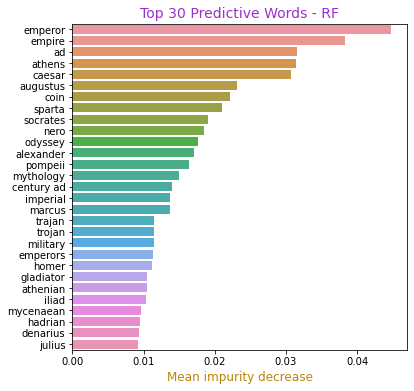

In [59]:
# call the function to print the bar chart
topwords_bar(temp_df['coef'], temp_df['top_words'],
            'Mean impurity decrease', 'RF')

Interpretation of RF word importance

- we are happy with the results of the word importance. after clean up the posts, updating stopwords and modifying the model, we have only the relevant, pertinent terms on the list of top 30 most predictive words
- there is a nice mix of terms associated with both ancient greece and rome among the top 30
- 22/30 are proper nouns

**Final word on word importance across different models**
- we will run word importance analysis only on our NB and RF models. SVM model (below) can calculate coefficients (importances) for individual features only with linear kernel, and our kernel will be polynomial. Polynomial kernel transforms data to another dimension, so the inputs are no longer interpretable. 
- NB gave us a much more informative look at the top words - broken down by the dependent variable category (greece and rome) - due to the way it is calculated. The feature_log_prob attribute in NB gives us the log probability of a word appearing given the fact the output is either rome or greece. Using the probability when the outcome is rome minus when the outcome is greece, singles out only those words that strongly contribute to only 1 category
- for that reason we were able to produce two tables/charts, ranking the important words for each subreddit
- RF as model is based on reducing impurity, so consequently, the feature_importance attribute ranks features according to how much they contributed to that decrease (of entropy in our case). As such, the feature_importance is not tied to the individual subreddit, so we were able to produce only one list - the list of top 30 most predictive words in our RF model
- nevertheless, the most predictive words lists for both RF and NB have a high number of common elements, which is encouraging, especially since the way the word importance is calculated is very different between the models

## SVM

### SVM w/cvec

In [60]:
param_svm1 = {'cvec__max_features': [4500, 7500],
#               'cvec__min_df':[2],
#               'cvec__ngram_range':[(1,2), (1,3)] # move it inside the vectorizer to save time
              'svm__C':np.logspace(-1,2,4, base=3),
    #           'svm__kernel':['poly', 'rbf','linear'],
#               'svm__gamma':['scale', 'auto'],
              'svm__coef0':[2,5]
             }

In [61]:
pipe_svm1 = Pipeline([
        ('cvec', CountVectorizer(stop_words=stopwords3_greek, min_df=2, ngram_range=(1,3))),
        ('svm', SVC(random_state=42, kernel='poly', degree=2))])

gs_svm1 = GridSearchCV(pipe_svm1, param_grid=param_svm1, cv=4, n_jobs=4)
gs_svm1.fit(X_train, y_train);

In [62]:
print('best params: ', gs_svm1.best_params_)
print('train score: ', gs_svm1.score(X_train, y_train))
print('test score: ', gs_svm1.score(X_test, y_test))
print('cross-val score: ', gs_svm1.best_score_)

pred_svm1 = gs_svm1.predict(X_test)

best params:  {'cvec__max_features': 7500, 'svm__C': 1.0, 'svm__coef0': 2}
train score:  0.9436687530091478
test score:  0.7971119133574007
cross-val score:  0.7811755319050295


### SVM w/tfidf & 8+ words

In [63]:
param_svm2 = {'tfidf__max_features': [3000, 5000],
#               'tfidf__min_df':[2],
#               'tfidf__ngram_range':[(1,2), (1,10)]
              'svm__C':np.logspace(-2,0,3, base=2),
    #           'svm__kernel':['poly', 'rbf','linear'],
#               'svm__gamma':['scale', 'auto'],
              'svm__coef0':[ 0.1, 0.5, 0.7]
             }

In [64]:
pipe_svm2 = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords3_greek, min_df=2, ngram_range=(1,3))),
        ('svm', SVC(random_state=42, kernel='poly', degree=2))])

gs_svm2 = GridSearchCV(pipe_svm2, param_grid=param_svm2, cv=5, n_jobs=4)
gs_svm2.fit(X_train1, y_train1);

In [65]:
print('best params: ', gs_svm2.best_params_)
print('train score: ', gs_svm2.score(X_train1, y_train1))
print('test score: ', gs_svm2.score(X_test1, y_test1))
print('cross-val score: ', gs_svm2.best_score_)

pred_svm2 = gs_svm2.predict(X_test1)

best params:  {'svm__C': 0.5, 'svm__coef0': 0.5, 'tfidf__max_features': 5000}
train score:  0.987846049966239
test score:  0.832995951417004
cross-val score:  0.803515678410282


- the results on these models are far from perfect, but at this stage, after many attempts, we will cease to tune them. In machine learning, in addition to overfitting the models, there is another trap called hyper-parameter overfitting. Just because our 100th combination of parameters leads to the best results, does not mean anything, except that, out of many combination, one of them will be the best on our particular combination of train and test data
- we will accept that there are limitations to these models and that improving accuracy while reducing the overfitting might be a fool's errand in some of these instances.
- a few, purpuseful stabs at parameter tuning in order to improve the model and cure a particular ill (such as overfitting by tuning a parameter such as C), are called for, but that should be enough.

In [66]:
display_scores('SVM/cvec',
               gs_svm1, X_train, X_test, y_train, y_test)
plot_cmatrix(y_test, pred_svm1)
print('\n\n\n')
display_scores('SVM/tfidf & 8+words',
               gs_svm2, X_train1, X_test1, y_train1, y_test1)
plot_cmatrix(y_test1, pred_svm2)

========== SVM/cvec ==========

Scores:
------------------------------ 

train score: 0.94
test score: 0.8
cross-validated score: 0.78

 Best Parameters:
------------------------------ 

cvec__max_features : 7500
svm__C : 1.0
svm__coef0 : 2


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,506,195
Actual Greece,86,598



Scores:
------------------------------ 

Rome recall:     0.72
Rome precision:   0.85
Greece recall:   0.87
Greece precision: 0.75




==== SVM/tfidf & 8+words =====

Scores:
------------------------------ 

train score: 0.99
test score: 0.83
cross-validated score: 0.8

 Best Parameters:
------------------------------ 

svm__C : 0.5
svm__coef0 : 0.5
tfidf__max_features : 5000


***Confusion Matrix***



,Predicted Rome,Predicted Greece
Actual Rome,424,93
Actual Greece,72,399



Scores:
------------------------------ 

Rome recall:     0.82
Rome precision:   0.85
Greece recall:   0.85
Greece precision: 0.81


- the last two models we ran in this project, the two SVMs, have one aspect that stands out ahead of all the others: they overfit a lot
- regularization efforts (keeping coefficients like C low) did not pay off, as the only way they succeeded to cure the overfitting  was at the expense of accuracy, which came down to 0.50 - the baseline effort
- another interesting aspect of these two models was in their confusion matrix. The cvec model which included greek-alphabet words in its features behaved similar to RF models - it predicted 'Greece' 57%. But unlike the RF models, once those words were removed (added to stopwords), the confusion matrix become normal in the sense that both recall and precision for both Rome and Greece was virtually the same.
- in terms of the overall accuracy scores, we like SVM the least as far as this project is concerned. Their test accuracy is at the low end at around 0.80, but the main drawback is extremely high overfitting with train scores as high as 0.99. Unless there were some crushing regularization parameters brought to bear on them (which brought them down to baseline accuracy) the overfitting was persistent and the train scores were in the high .90s
- due to that, we wouldn't have confidence in these models to conduct research for the University.

## Wrong predictions (ii)

- now that our modeling is done, it is always good to see if there is anything to be learned from wrong prediction. we already have wrong_df from model 1, which contains all the misclassification. (model 1 is not our production model, but it is close enough)
- the goal of this section will be to get top10 words by frequency in posts that were classified as rome instead of greece and vice versa

In [67]:
wrong_df.head()

,text,predicted,actual,wordcount
0,byzantines greeks romans or greeks cosplaying a romans so this be a controversial topic especially among roman history enthusiast less among roman history scholar but i want the opinion of some of...,Rome,Greece,374
1,bettany hughes documentary about the roman god bacchus,Greece,Rome,8
2,worst omens in ancient history,Rome,Greece,5
3,saw this today on too good not to post,Greece,Rome,9
4,hope you recognise a couple of these mince pie design,Rome,Greece,10


In [68]:
#vectorize with the most updated stopword list
cvec_w = CountVectorizer(stop_words=stopwords3_greek)

In [69]:
# get individual words through vectorization
wrong_rome = pd.DataFrame(cvec_w.fit_transform(wrong_df[wrong_df['actual']=='Greece']['text']).todense(),
                           columns=cvec_w.get_feature_names())
wrong_greece = pd.DataFrame(cvec_w.fit_transform(wrong_df[wrong_df['actual']=='Rome']['text']).todense(),
                           columns=cvec_w.get_feature_names())

In [70]:
# creat two panda series for easy charting
wrong_Rome = wrong_rome.sum().sort_values(ascending=False)[0:10]
wrong_Greece = wrong_greece.sum().sort_values(ascending=False)[0:10]

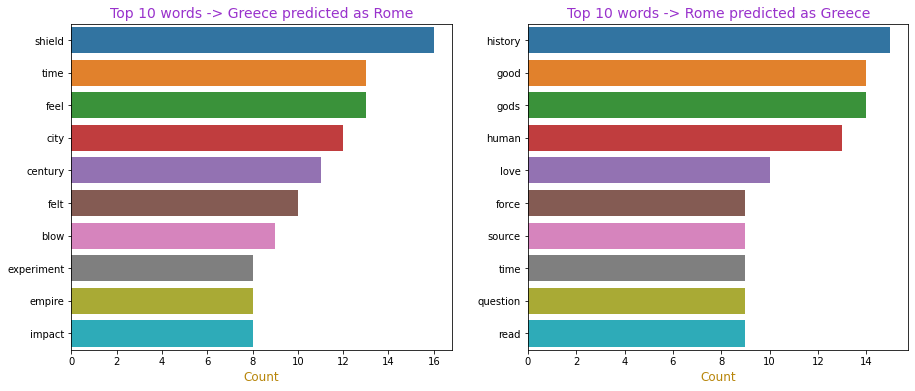

In [71]:
#unfortunately we can't use our topwords_bar function since it caters to different sorts of data
fig, ax = plt.subplots(1,2, figsize=(15,6))

pair = ['Rome', 'Greece']

for i in [(0, wrong_Rome), (1, wrong_Greece)]:
    sns.barplot(x = i[1], y=i[1].index, ax=ax[i[0]])
    ax[i[0]].set_title(f'Top 10 words -> {pair[1-i[0]]} predicted as {pair[i[0]]}', fontsize=14, 
                 color='Darkorchid') # a bit convoluted, but it saves us doing it twice
    
    ax[i[0]].set_xlabel('Count', fontsize=12, color='darkgoldenrod')

plt.show()

- no major revelation here except that the word 'empire',  which was listed as the number one most predictive word for Rome, also found its way as a word that causes Greek posts to be mistaken for roman, which makes it a bit of a double-edged sword
- while these two lists will not currently cause us to adjust our model/stopwords, it is useful to check them periodically to see if any new words are creeping in that cause our model's performance to sour.
- in the future, try to automate a process whereby these most common words from 'wrong_df' get added to the stopwords list. words like empire are on both 'most wrong' and 'most predictive' lists, we would have to check both lists to see if the word gets added.

## Final model visualizations

| No |          MODEL (vector)         | train<br>accuracy | test<br>accuracy |                                                                         parameters |                                     other features |                                                                                                  comments                                                                                                  |
|----|:-------------------------------:|------------------:|------------------|-----------------------------------------------------------------------------------:|---------------------------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| 1  |    Naive Bayes<br>(countvec)    |              0.88 | 0.81             |                                             max_feat:4000<br>min_df:3<br>alpha:0.5 |                    nothing extra<br>- simple model |                                                                        first model after baseline, already<br>shown good improvement                                                                       |
| 2  |    Naive Bayes<br>(countvec)    |              0.90 | 0.84             |                                             max_feat:2500<br>min_df:4<br>alpha:0.1 |                       only posts <br>with 8+ words |                                                after testing the wrong predictions<br>from model 1, only longer posts were<br>taken. immediate improvement.                                                |
| 3  |      Naive Bayes<br>(tfidf)     |              0.91 | 0.81             |                                             max_feat:4000<br>min_df:3<br>alpha:0.5 |                                               none |                                                                         tfidf vectorization didn't bring<br>about much improvement                                                                         |
| 4  |      Naive Bayes<br>(tfidf)     |              0.93 | 0.85             |                                             max_feat:4000<br>min_df:3<br>alpha:0.5 |                       only posts <br>with 8+ words |                                                             - best score so far<br>- minimal tuning required, so very<br>easy and quick to run                                                             |
| 5  |    Naive Bayes<br>(countvec)    |              0.87 | 0.80             |                                             max_feat:4000<br>min_df:3<br>alpha:0.5 |                                    extra stopwords |                                                          - similar results to model 1 but with<br>more stopwords, therefore considered<br>a succes                                                         |
| <span style="color:red">6</span> |  <span style="color:red">    Naive Bayes<br>(tfidf)   </span>  |    <span style="color:red">          0.93</span> | <span style="color:red">0.84</span>             |                                             <span style="color:red">max_feat:4000<br>min_df:3<br>alpha:0.5 |<span style="color:red"> only post with<br>8+ words, and<br>extra stopwords</span> |        <span style="color:red">                                                       - simple model with best scores<br>- production model<br>- simple to tune</span>                                                              |
| 7  |   Random Forest<br>(countvec)   |              0.81 | 0.78             |  max_feat:4000<br>criterion:entropy<br>max_depth:5<br>min_leaf:2<br>estimators:300 |                                    extra stopwords |                                                         -random forest did not show as high<br>accuracy as NB<br>- predicted Greece 60% of the time                                                        |
| 8  |     Random Forest<br>(tfidf)    |              0.81 | 0.76             | max_feat:4000<br>criterion:entropy<br>max_depth:12<br>min_leaf:1<br>estimators:300 | only post with<br>8+ words, and<br>extra stopwords | -hard to tune. started with params for<br>model 7, but it wasn't even close<br>- accuracy was initially awful, but <br>with very high max_depth got close to<br>model 7<br>-predicted Rome 67% of the time |
| 9  | 2nd deg Poly SVM,<br>(countvec) |              0.94 | 0.80             |                                                    max_feat:7500<br>C:1<br>coef0:2 |                                    extra stopwords |                   -big difference between train and test<br>- indicative of overfitting<br>- no amount of parameter tuning could <br>reduce overfitting<br>-predicted greece 57% outcomes                  |
| 10 |   2nd deg Poly SVM,<br>(tfidf)  |              0.99 | 0.83             |                                                                              0.901 | only post with<br>8+ words, and<br>extra stopwords |                                            -even worse overfitting than model 9<br>- adding greek stopwords made the model<br>balanced in its prediction (50:50)                                           |

*production model in red

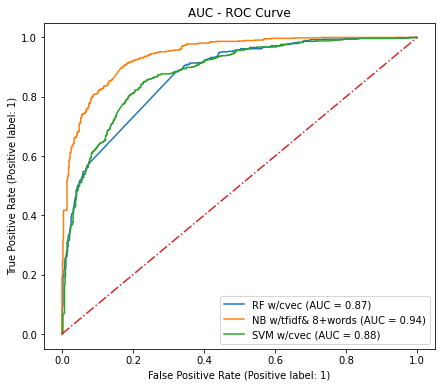

In [86]:
fig, ax = plt.subplots(figsize=(7,6))
plot_roc_curve(gs_rf1, X_test, y_test, name='RF w/cvec', ax=ax)
plot_roc_curve(gs5, X_test, y_test, name='NB w/tfidf& 8+words', ax=ax)
plot_roc_curve(gs_svm1, X_test, y_test, name='SVM w/cvec', ax=ax)
plt.plot([0,1], [0,1], linestyle='-.')
plt.title('AUC - ROC Curve')
plt.show()

 - our NB model (yellow) clearly outperforms the best RF and SVM models, as it is closest to the top left corner of the chart
 - other NB models (not shown for clarity) actually have pretty similar plots to the yellow line here, but our was chosen due to other advantages such as overcoming more stopwords and discounting spam

## Conclusions

- our production model, among others, proves that distinguishing among historical topics is possible for a machine, and that reddit can be harnessed for that purpose. we got high accuracy scores despite the fact that, as described in the beginning of the project, around 60% of top words in both subreddits are the same
- rather than using reddit, it might be possible to train the model on proper nouns only (countries, kings, named war) from the relevant historical period. we noticed that some 75% of the top 30 predictors are proper nouns
- while the topics were simililar, we were lucky that the political orientation of ancient rome and greece was different - one was an empire and the other was not. words 'empire' and 'emperor' score very high on our predictor strenght lists. in the future, when comparing two empires (or two kindomns), the model might face a more uphill battle
- just because a word is a strong predictor, does not mean that we should not be careful in how we treat it. We saw the word 'emperor', the most important word for predicting the roman subreddit, was also one of the top words among misclassified posts. every time that word ended up in a greek reddit, the post automatically got wrongly classified as roman
- choice of models and stopwords is the key to success. models can be left to data scientists, but the choice of stopwords can be tricky and we should seek input from the experts in the academic field
- in a long run, having a model that is simple, reliable, interpretable and low-maintenance is paramount to ensure University's commitment to the project. That is why we chose NB model from section 2.7. It required very little paramenter tuning (changing the parameters didn't affect the scores much), it excluded many posts and words making it less susceptible to spam, it had great accuracy scores and it wasn't biased towards choosing either subreddit.
- with more resources, building a language library would provide most benefits when it comes to international history. Basing decision on foreign alpahbets rather than excluding them through stopwords would definitely benefit the scores
- as University's goal is not to make money, but rather, to promote academic research, our projects wasn't as focused on uncovering the inclinations and propensities of the people who write the posts in order to target them with adds. Still, while we don't have to worry about who writes the posts that our model reads, we do have to worry about academics who will use our model to get their weekly or monthly rundown of what was published in their field. Testing the wrong predictions and lists of important words regularly can therefore serve as an early warning system of intrusion of spam into our dataset, and thus ensure quality product for professors, researches and students for years to come

## Issues with our model
- ancient rome/greece is the first model developed as part of our effort to develop a machine-learning product that can search the internet for content from various academic disciplines. future models to distinguish different pairs of topics will be much faster and easier to implement
- there will however be some stumbling blocks. one that sticks out in particular is the issue of stopwords. we relied a lot on them to train the model properly and it took us a few iterations until we settled on the set of stopwords that works well. Each new topic would require a completely new set of stopwords added to the default ones.
- as individual models are concerned, we chose a particular Naive Bayes one for its simplicity, accuracy and interpretability. SVM shows a lot of promise by being able to predict training data with almost 100% accuracy. if we can invest more time and training into it, maybe it could increase its test scores as well, and become our go-to model 
- another advantage of our chosen model is that it didn't use any greek words to aid it in prediction. however, if more foreign alphabets get scraped into our future data (chinese, arabic), removing them might not be the proper course of action. Using only latin letters will prove to be a huge drawback, especially in the history deparment that deals in many different cultures, letters and languages, some of them extinct
- one of the unusual aspects of our model is how random forest and SVM vacillated between overpredicting greece to overpredicting rome based upon the stopwords given,  while Naive Bayes did not. We would love to subject this oddity to greater scrutiny when time allows.
- we did a study of the most common words found in wrongly classified posts. later on, we should follow up on it, and add some of those words to the list of stopwords to see if there's an improvement in performance. if yes, automate the procedure.

## Next steps

As stated in the background section of this project, we envision this entire project to be just the first step in unfettered internet search for any material that relates to any of the University's academic departments. No person can keep up with the amount of materials that get published daily, and intelligent machines doing the search work for us is the only way to go. The next steps will be, in order:
- get feedback from the University on the current model, make improvements based on it.
- expand the model to be able to recognize more historical topics, and not just two, but 3, 4,...n at a time
- configure the model to be able to categorize text as 'other' when it does not meet the threshold required to be put in any of the proposed categories
- once historical topics are exhausted, repeat the process in other academic fields